In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Lambda, InputLayer, concatenate, Activation, Flatten, Reshape, Conv2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.losses import MSE
from tensorflow.keras import Input
import os
import zipfile
import pathlib
from tensorflow.keras.models import Model, Sequential
%matplotlib inline

TensorFlow 2.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Creating dataset from aligned and cropped Celeba images
Image properties: 178x218 jpeg ~ 8kb

Shareble link to the archive\
https://drive.google.com/open?id=132WAcWV3Ip-ROMklZNqRPWHqCSW4yAhq

In [0]:
!unzip '/content/drive/My Drive/img_align_celeba.zip' -d '/content/' -q

In [0]:
# path = '/content/lfw-deepfunneled/'
# data_root = pathlib.Path(path)

In [0]:
# image_paths = list(data_root.glob('*/*'))

In [0]:
# image_paths = [str(path) for path in image_paths]

In [0]:
image_paths = ['/content/img_align_celeba/' + img_name for img_name in os.listdir('/content/img_align_celeba')]

In [0]:
path_ds = tf.data.Dataset.from_tensor_slices(image_paths)

In [0]:
image_size = 64
batch_size = 128

In [0]:
def preprocess_image(image, image_size):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (178,218))
    image_cropped = image[25:-25, 45:-45]
    image_cropped = tf.image.resize(image_cropped, (image_size,image_size)) / 255
    return image_cropped

def preprocess_and_load_image(image_path):
    image = tf.io.read_file(image_path)
    image = preprocess_image(image,image_size)
    return image

In [0]:
# ifw_ds = path_ds.map(preprocess_and_load_image)
celeba_ds = path_ds.map(preprocess_and_load_image)

In [0]:
# ifw_ds= ifw_ds.shuffle(buffer_size=13236)
# ifw_ds = ifw_ds.repeat()
# ifw_ds = ifw_ds.batch(batch_size=batch_size, drop_remainder=True)
# celeba_ds= celeba_ds.shuffle()
# celeba_ds = celeba_ds.repeat()
celeba_ds = celeba_ds.batch(batch_size=batch_size, drop_remainder=True)

In [11]:
# ifw_ds = tf.data.Dataset.zip((ifw_ds, ifw_ds))
# ifw_ds.element_spec
celeba_ds = tf.data.Dataset.zip((celeba_ds, celeba_ds))
celeba_ds.element_spec

(TensorSpec(shape=(128, 64, 64, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(128, 64, 64, 3), dtype=tf.float32, name=None))

In [12]:
# ifw_ds.cache()
# ifw_ds.prefetch(100)
celeba_ds.prefetch(100)

<PrefetchDataset shapes: ((128, 64, 64, 3), (128, 64, 64, 3)), types: (tf.float32, tf.float32)>

## Defining VAE

In [0]:
def create_encoder(input_dims, base_filters=64, layers=2, latent=512):
    w = input_dims[0]//2**layers
    h = input_dims[1]//2**layers
    c = base_filters*2**(layers-1)
    encoder = Sequential()
    encoder.add(InputLayer(input_dims))
    for i in range(layers):
        encoder.add(Conv2D(filters=base_filters*2**i, kernel_size=(5, 5),
                           strides=(2, 2), padding='same', use_bias=False, activation='relu'))
        encoder.add(BatchNormalization(axis=3))
    encoder.add(Reshape([w*h*c]))
    encoder.add(Dense(latent*2))
    return encoder

In [0]:
def sample(mean_log_var):
    mean, log_var = mean_log_var
    eps_shape = mean.shape
    epsilon = tf.random.normal(shape = eps_shape)
    z = epsilon*tf.math.exp(log_var/2)+mean
    return z

In [0]:
def create_decoder(output_dims, base_filters=64, layers=2, latent=512):
    w = output_dims[0]//2**layers
    h = output_dims[1]//2**layers
    c = base_filters*2**(layers-1)
    decoder = Sequential()
    decoder.add(InputLayer((latent)))
    decoder.add(Dense(w*h*c))
    decoder.add(Reshape([w, h, c]))
    for i in range(layers-1, 0, -1):
        decoder.add(Conv2DTranspose(filters=base_filters*2**i, kernel_size=(5, 5),
                             strides=(2, 2), padding='same', use_bias=False, activation='relu'))
        decoder.add(BatchNormalization(axis=3))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=(5, 5),
                         strides=(2, 2), padding='same',activation='sigmoid'))
    return decoder


In [0]:
def create_vae(batch_size, base_filters=128, latent=8,
               image_size=64, layers=2):
    """
    Constructs VAE model with given parameters.
    :param batch_size: size of a batch (used for placeholder)
    :param base_filters: number of filters after first layer.
        Other layers will double this number
    :param latent: latent space dimension
    :param image_size: size of input image
    Returns compiled Keras model along with encoder and decoder
    """
    if isinstance(image_size, int):
        image_size = (image_size, image_size)
    x = Input( shape=(image_size[0], image_size[1], 3), batch_size=batch_size)
    encoder = create_encoder([image_size[0], image_size[1], 3],
                             base_filters=base_filters,
                             latent=latent,
                             layers=layers)
    decoder = create_decoder([image_size[0], image_size[1], 3],
                             base_filters=base_filters,
                             latent=latent,
                             layers=layers)
    mean_log_var = encoder(x)
    mean, log_var = tf.split(mean_log_var, num_or_size_splits=2, axis=1)
    z = Lambda(sample)([mean, log_var])
    reconstruction = decoder(z)
    
    vae = Model(x, reconstruction)
    # loss = vlb_mse_kl(x, reconstruction, mean, log_var, reconstruction_weight)
    # # vae.compile(optimizer=keras.optimizers.RMSprop(lr=learning_rate),
    #             loss=lambda x, y: loss)
    return vae, encoder, decoder

In [0]:
class vlb_mse_kl(tf.keras.losses.Loss):
    
    def __init__(self,  reconstruction_weight=1):
        self. reconstruction_weight = reconstruction_weight
        super().__init__()
    
    def call(self, y_true, y_pred):
        t_mean, t_log_var = tf.split(encoder(y_true), num_or_size_splits=2, axis=1)
        log_likelihood = -0.5 * self.reconstruction_weight * tf.reduce_sum((y_true - y_pred)**2, axis=[1,2,3])
        KL = 0.5 * tf.reduce_sum((-t_log_var + tf.math.square(t_mean) + tf.math.exp(t_log_var) - 1), axis=1)
        return -tf.reduce_mean((log_likelihood - KL))

In [0]:
base_filters = 256
layers = 4
latent_size = 8

In [0]:
vae, encoder, decoder = create_vae(layers=layers, batch_size=batch_size, latent=latent_size, image_size=image_size, base_filters=base_filters)

In [0]:
learning_rate = 0.00001
reconstruction_weight = 1

In [0]:
loss = vlb_mse_kl(reconstruction_weight=reconstruction_weight)

In [0]:
vae.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),
                loss=loss)

In [0]:
# vae.load_weights('/content/drive/My Drive/models/VAE_celeba/checkpoints/VAE_celeba_img64_filt256_4layers_16lsize_3_recon1000.h5')

##Training VAE

In [0]:
create_checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/drive/My Drive/models/VAE_celeba/checkpoints/VAE_celeba_img64_filt256_4layers_8lsize.h5', save_weights_only=True)

In [0]:
hist = vae.fit(x=celeba_ds, epochs=5,  callbacks = [create_checkpoint], verbose=1)

Train for 1582 steps
Epoch 1/5
 813/1582 [==============>...............] - ETA: 23:33 - loss: 191.1765

In [0]:
vae.save_weights('/content/drive/My Drive/models/VAE_celeba/VAE_celeba_img64_filt256_4layers_8lsize.h5')

## Cheking Results

### Sampling

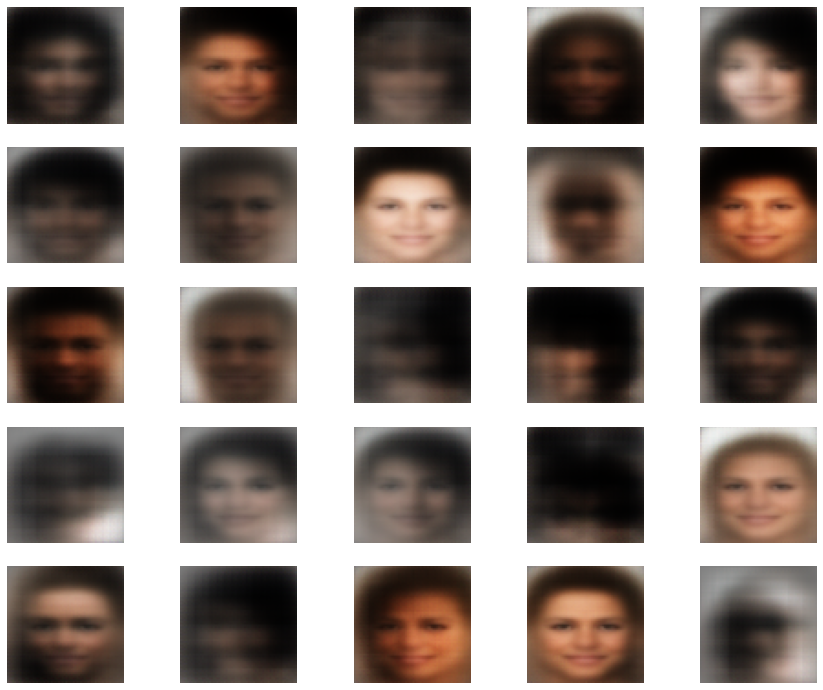

In [0]:
n_samples = 25
z = tf.random.normal(shape = (n_samples, latent_size))
images = decoder(z)
figure = plt.figure(figsize=(15,15))
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1 , 5, i + 1)
    plt.imshow(images[i])
    ax.axis('off')
plt.show()

### Processing images

In [0]:
def encode_decode(n, dataset):
    img_size = image_size
    x = np.zeros((n, img_size, img_size, 3))
    for i, img in enumerate(dataset.take(n)):
        random_index = int(np.random.uniform() * 127)
        img = img[0][random_index]
        x[i] = img
    decoded_x = vae(x)
    return x, decoded_x


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



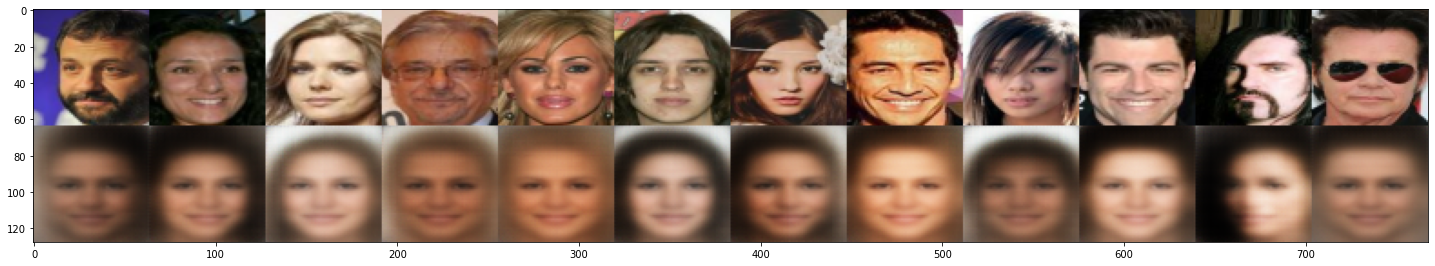

In [0]:
n = 12
dataset = celeba_ds

fig = plt.figure(figsize=(25, 25))
figure = np.zeros((image_size * 2, image_size * n, 3)) 

plot_data = encode_decode(n, dataset)
# plt.imshow(plot_data[0][0])
for i in range(n):
    figure[:image_size, i * image_size: (i + 1) * image_size, :] = plot_data[0][i]
    figure[image_size:, i * image_size: (i + 1) * image_size, :] = plot_data[1][i]
plt.imshow(figure)